In [25]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct
import os
from tqdm import tqdm
from tqdm import trange
from tensorflow.python.client import device_lib


![lables_ubyte_structure](img/labels.png)

In [26]:
def load_mnist_train(path, kind='train'): 
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

![images_ubyte_structure](img/images.png)

In [27]:
def load_mnist_test(path, kind='t10k'): 
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind) 
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind) 
    with open(labels_path, 'rb') as lbpath: 
        magic, n = struct.unpack('>II',lbpath.read(8)) 
        labels = np.fromfile(lbpath,dtype=np.uint8) 
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [28]:
def check_available_gpus():
    local_devices = device_lib.list_local_devices()
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    gpu_num = len(gpu_names)
    print('{0} GPUs are detected : {1}'.format(gpu_num, gpu_names))
    return gpu_num

In [29]:
check_available_gpus()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1 GPUs are detected : ['/device:GPU:0']


In [30]:
path = os.getcwd()
train_images, train_labels = load_mnist_train(path)
test_images, test_labels = load_mnist_test(path)
print(len(train_images))

60000


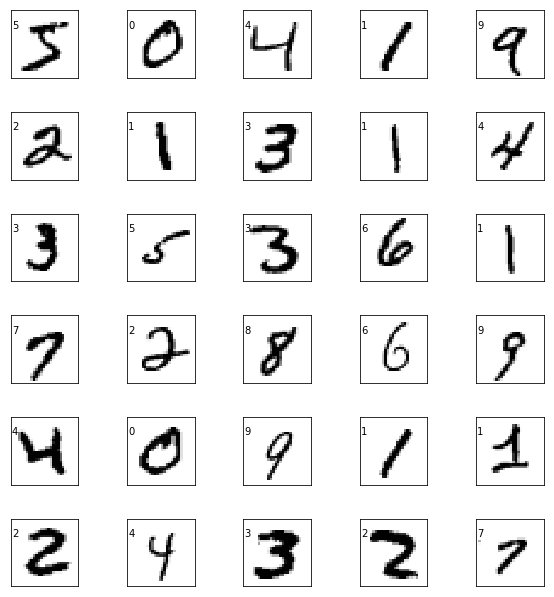

In [21]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
for i in range(30):
    image = np.reshape(train_images[i],[28,28])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
    ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [31]:
train_epochs = 300
batch_size = 5000
noise_factor = 0.5

Input_height = 28
Input_width = 28

input_x = tf.placeholder(tf.float32, shape=[None, Input_height * Input_width], name='input')
input_matrix = tf.reshape(input_x, shape=[-1, Input_height, Input_width, 1])


#encode_processing
#input 28*28
#output 14*14*32
kernal_1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,32], stddev=0.1, name='kernal_1'))
bias_1 = tf.Variable(tf.constant(0.0, shape=[32], name='bias_1'))
conv1 = tf.nn.conv2d(input=input_matrix, filter=kernal_1, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.bias_add(conv1, bias_1, name='conv_1')
activ_1 = tf.nn.relu(conv1, name='activ_1')
pool1 = tf.nn.max_pool(value=activ_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='max_pool_1')
#pool1 = tf.layers.batch_normalization(pool1)


#input 14*14*32
#output 7*7*32
kernal_2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 32], stddev=0.1, name='kernal_2'))
bias_2 = tf.Variable(tf.constant(0.0, shape=[32], name='bias_2'))
conv2 = tf.nn.conv2d(input=pool1, filter=kernal_2, strides=[1, 1, 1, 1], padding='SAME')
conv2 = tf.nn.bias_add(conv2, bias_2, name='conv_2')
activ_2 = tf.nn.relu(conv2, name='activ_2')
pool2 = tf.nn.max_pool(value=activ_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_2')
#pool2 = tf.layers.batch_normalization(pool2)

#input 7*7*32
#output 4*4*16
kernal_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 16], stddev=0.1, name='kernal_3'))
bias_3 = tf.Variable(tf.constant(0.0, shape=[16]))
conv3 = tf.nn.conv2d(input=pool2, filter=kernal_3, strides=[1, 1, 1, 1], padding='SAME')
conv3 = tf.nn.bias_add(conv3, bias_3)
activ_3 = tf.nn.relu(conv3, name='activ_3')
pool3 = tf.nn.max_pool(value=activ_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_3')
#pool3 = tf.layers.batch_normalization(pool3)

#input 4*4*16
#output 1*1*64
kernal_4 = tf.Variable(tf.truncated_normal(shape=[4, 4, 16, 64], stddev=0.1, name='kernal_4'))
bias_4 = tf.Variable(tf.constant(0.0, shape=[64]))
conv4 = tf.nn.conv2d(input=pool3, filter=kernal_4, strides=[1, 1, 1, 1], padding='VALID')
conv4 = tf.nn.bias_add(conv4, bias_4)
activ_4 = tf.nn.relu(conv4, name='activ_4')
pool4 = tf.nn.max_pool(value=activ_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_4')
feature = tf.squeeze(pool4,axis=(1,2))

#decode_processing
deconv_weight_0 = tf.Variable(tf.truncated_normal(shape=[4, 4, 16, 64], stddev=0.1), name='deconv_weight_0')
deconv0 = tf.nn.conv2d_transpose(value=pool4, filter=deconv_weight_0, output_shape=[batch_size, 4, 4, 16], strides=[1, 2, 2, 1], padding='SAME', name='deconv_1')


#input 4*4*16
#output 7*7*32
deconv_weight_1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 16], stddev=0.1), name='deconv_weight_1')
deconv1 = tf.nn.conv2d_transpose(value=pool3, filter=deconv_weight_1, output_shape=[batch_size, 7, 7, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_1')

 
## 2 deconv layer
## input 7*7*32
## output 14*14*32
deconv_weight_2 = tf.Variable(tf.truncated_normal(shape=[3, 3,32, 32], stddev=0.1), name='deconv_weight_2')
deconv2 = tf.nn.conv2d_transpose(value=deconv1, filter=deconv_weight_2, output_shape=[batch_size, 14, 14, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_2')
 

## 3 deconv layer
## input 14*14*32
## output 28*28*32
deconv_weight_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 32], stddev=0.1, name='deconv_weight_3'))
deconv3 = tf.nn.conv2d_transpose(value=deconv2, filter=deconv_weight_3, output_shape=[batch_size, 28, 28, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_3')


##CONV Layer
##input 28*28*32
##output 28*28*1
weight_final = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 1], stddev=0.1, name = 'weight_final'))
bias_final = tf.Variable(tf.constant(0.0, shape=[1], name='bias_final'))
conv_final = tf.nn.conv2d(input=deconv3, filter=weight_final, strides=[1, 1, 1, 1], padding='SAME')
conv_final = tf.nn.bias_add(conv_final, bias_final, name='conv_final')

output = tf.reshape(conv_final, shape=[-1,Input_height*Input_width])

loss = tf.reduce_mean(tf.pow(tf.subtract(output, input_x), 2.0),name='loss')
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
saver = tf.train.Saver()

In [32]:
if not os.path.exists('tmp/'):
    os.mkdir('tmp/')
print(np.shape(feature))

(?, 64)


In [34]:
#Training processing:
train_x = np.zeros((len(train_images),64))
with tf.Session() as sess:
    if os.path.exists('tmp/checkpoint'):
        saver.restore(sess, 'tmp/model.ckpt')
    else:
        sess.run(tf.global_variables_initializer())
    total_batch  = int(len(train_images)/batch_size)
    min_lose = float('inf')
    msg = "Global Step={:d}, lose={:.4f}"
    try:
        with tqdm(range(train_epochs)) as t:           
            for e in t:    
                for b in range(total_batch):
                    batch = train_images[b*batch_size:(b+1)*batch_size]
                    imgs = batch.reshape((-1,28,28,1))
                    feature1,batch_cost, _=sess.run([feature,loss, optimizer],feed_dict={input_x:batch})
                    train_x[b*batch_size:(b+1)*batch_size]=np.array(feature1)
                    if(batch_cost<min_lose):
                        min_lose = batch_cost
                        saver.save(sess, 'tmp/model.ckpt')
                print(msg.format(e,min_lose))
    except KeyboardInterrupt:
        t.close()
        raise
    t.close()


INFO:tensorflow:Restoring parameters from tmp/model.ckpt


  0%|          | 1/300 [00:04<20:29,  4.11s/it]

Global Step=0, lose=1079.2633


  1%|          | 2/300 [00:07<19:40,  3.96s/it]

Global Step=1, lose=1075.0864


  1%|          | 3/300 [00:11<18:59,  3.84s/it]

Global Step=2, lose=1075.0864


  1%|▏         | 4/300 [00:14<18:29,  3.75s/it]

Global Step=3, lose=1075.0864


  2%|▏         | 5/300 [00:18<18:15,  3.71s/it]

Global Step=4, lose=1073.2269


  2%|▏         | 6/300 [00:21<17:57,  3.67s/it]

Global Step=5, lose=1073.2269


  2%|▏         | 7/300 [00:25<17:47,  3.64s/it]

Global Step=6, lose=1073.2269


  3%|▎         | 8/300 [00:29<17:39,  3.63s/it]

Global Step=7, lose=1073.2269


  3%|▎         | 9/300 [00:32<17:37,  3.64s/it]

Global Step=8, lose=1070.7339


  3%|▎         | 10/300 [00:36<17:28,  3.62s/it]

Global Step=9, lose=1070.7339


  4%|▎         | 11/300 [00:40<17:28,  3.63s/it]

Global Step=10, lose=1066.2949


  4%|▍         | 12/300 [00:43<17:21,  3.62s/it]

Global Step=11, lose=1066.2949


  4%|▍         | 13/300 [00:47<17:22,  3.63s/it]

Global Step=12, lose=1065.1851


  5%|▍         | 14/300 [00:50<17:14,  3.62s/it]

Global Step=13, lose=1065.1851


  5%|▌         | 15/300 [00:54<17:09,  3.61s/it]

Global Step=14, lose=1065.1851


  5%|▌         | 16/300 [00:58<17:04,  3.61s/it]

Global Step=15, lose=1065.1851


  6%|▌         | 17/300 [01:01<17:01,  3.61s/it]

Global Step=16, lose=1065.1851


  6%|▌         | 18/300 [01:05<16:58,  3.61s/it]

Global Step=17, lose=1065.1851


  6%|▋         | 19/300 [01:08<16:53,  3.61s/it]

Global Step=18, lose=1065.1851


  7%|▋         | 20/300 [01:12<16:51,  3.61s/it]

Global Step=19, lose=1065.1851


  7%|▋         | 21/300 [01:16<16:47,  3.61s/it]

Global Step=20, lose=1065.1851


  7%|▋         | 22/300 [01:19<16:44,  3.61s/it]

Global Step=21, lose=1065.1851


  8%|▊         | 23/300 [01:23<16:40,  3.61s/it]

Global Step=22, lose=1065.1851


  8%|▊         | 24/300 [01:27<16:37,  3.61s/it]

Global Step=23, lose=1065.1851


  8%|▊         | 25/300 [01:30<16:34,  3.62s/it]

Global Step=24, lose=1065.1851


  9%|▊         | 26/300 [01:34<16:30,  3.62s/it]

Global Step=25, lose=1065.1851


  9%|▉         | 27/300 [01:38<16:40,  3.66s/it]

Global Step=26, lose=1062.1702


  9%|▉         | 28/300 [01:41<16:32,  3.65s/it]

Global Step=27, lose=1062.1702


 10%|▉         | 29/300 [01:45<16:26,  3.64s/it]

Global Step=28, lose=1062.1702


 10%|█         | 30/300 [01:48<16:20,  3.63s/it]

Global Step=29, lose=1062.1702


 10%|█         | 31/300 [01:52<16:16,  3.63s/it]

Global Step=30, lose=1062.1702


 11%|█         | 32/300 [01:56<16:11,  3.62s/it]

Global Step=31, lose=1062.1702


 11%|█         | 33/300 [01:59<16:07,  3.62s/it]

Global Step=32, lose=1062.1702


 11%|█▏        | 34/300 [02:03<16:05,  3.63s/it]

Global Step=33, lose=1062.1702


 12%|█▏        | 35/300 [02:07<16:15,  3.68s/it]

Global Step=34, lose=1062.1702


 12%|█▏        | 36/300 [02:10<16:15,  3.69s/it]

Global Step=35, lose=1057.2272


 12%|█▏        | 37/300 [02:14<16:24,  3.74s/it]

Global Step=36, lose=1051.4708


 13%|█▎        | 38/300 [02:18<16:10,  3.71s/it]

Global Step=37, lose=1051.4708


 13%|█▎        | 39/300 [02:21<16:00,  3.68s/it]

Global Step=38, lose=1051.4708


 13%|█▎        | 40/300 [02:25<15:51,  3.66s/it]

Global Step=39, lose=1051.4708


 14%|█▎        | 41/300 [02:29<15:45,  3.65s/it]

Global Step=40, lose=1051.4708


 14%|█▍        | 42/300 [02:32<15:39,  3.64s/it]

Global Step=41, lose=1051.4708


 14%|█▍        | 43/300 [02:36<15:33,  3.63s/it]

Global Step=42, lose=1051.4708


 15%|█▍        | 44/300 [02:40<15:28,  3.63s/it]

Global Step=43, lose=1051.4708


 15%|█▌        | 45/300 [02:43<15:24,  3.62s/it]

Global Step=44, lose=1051.4708


 15%|█▌        | 46/300 [02:47<15:20,  3.62s/it]

Global Step=45, lose=1051.4708


 16%|█▌        | 47/300 [02:50<15:15,  3.62s/it]

Global Step=46, lose=1051.4708


 16%|█▌        | 48/300 [02:54<15:12,  3.62s/it]

Global Step=47, lose=1051.4708


 16%|█▋        | 49/300 [02:58<15:26,  3.69s/it]

Global Step=48, lose=1044.1165


 17%|█▋        | 50/300 [03:02<15:17,  3.67s/it]

Global Step=49, lose=1044.1165


 17%|█▋        | 51/300 [03:05<15:09,  3.65s/it]

Global Step=50, lose=1044.1165


 17%|█▋        | 52/300 [03:09<15:03,  3.64s/it]

Global Step=51, lose=1044.1165


 18%|█▊        | 53/300 [03:12<14:57,  3.63s/it]

Global Step=52, lose=1044.1165


 18%|█▊        | 54/300 [03:16<14:52,  3.63s/it]

Global Step=53, lose=1044.1165


 18%|█▊        | 55/300 [03:20<14:48,  3.62s/it]

Global Step=54, lose=1044.1165


 19%|█▊        | 56/300 [03:23<14:43,  3.62s/it]

Global Step=55, lose=1044.1165


 19%|█▉        | 57/300 [03:27<14:39,  3.62s/it]

Global Step=56, lose=1044.1165


 19%|█▉        | 58/300 [03:30<14:36,  3.62s/it]

Global Step=57, lose=1044.1165


 20%|█▉        | 59/300 [03:34<14:33,  3.62s/it]

Global Step=58, lose=1044.1165


 20%|██        | 60/300 [03:38<14:29,  3.62s/it]

Global Step=59, lose=1044.1165


 20%|██        | 61/300 [03:41<14:25,  3.62s/it]

Global Step=60, lose=1044.1165


 21%|██        | 62/300 [03:45<14:21,  3.62s/it]

Global Step=61, lose=1044.1165


 21%|██        | 63/300 [03:49<14:17,  3.62s/it]

Global Step=62, lose=1044.1165


 21%|██▏       | 64/300 [03:52<14:13,  3.62s/it]

Global Step=63, lose=1044.1165


 22%|██▏       | 65/300 [03:56<14:10,  3.62s/it]

Global Step=64, lose=1044.1165


 22%|██▏       | 66/300 [03:59<14:12,  3.64s/it]

Global Step=65, lose=1041.5048


 22%|██▏       | 67/300 [04:03<14:07,  3.64s/it]

Global Step=66, lose=1041.5048


 23%|██▎       | 68/300 [04:07<14:01,  3.63s/it]

Global Step=67, lose=1041.5048


 23%|██▎       | 69/300 [04:10<13:57,  3.63s/it]

Global Step=68, lose=1041.5048


 23%|██▎       | 70/300 [04:14<13:53,  3.62s/it]

Global Step=69, lose=1041.5048


 24%|██▎       | 71/300 [04:18<13:50,  3.63s/it]

Global Step=70, lose=1041.5048


 24%|██▍       | 72/300 [04:21<13:59,  3.68s/it]

Global Step=71, lose=1040.3448


 24%|██▍       | 73/300 [04:25<13:51,  3.67s/it]

Global Step=72, lose=1040.3448


 25%|██▍       | 74/300 [04:29<13:49,  3.67s/it]

Global Step=73, lose=1040.3448


 25%|██▌       | 75/300 [04:32<13:44,  3.66s/it]

Global Step=74, lose=1040.3448


 25%|██▌       | 76/300 [04:36<13:40,  3.66s/it]

Global Step=75, lose=1040.3448


 26%|██▌       | 77/300 [04:40<13:34,  3.65s/it]

Global Step=76, lose=1040.3448


 26%|██▌       | 78/300 [04:43<13:35,  3.67s/it]

Global Step=77, lose=1031.0697


 26%|██▋       | 79/300 [04:47<13:28,  3.66s/it]

Global Step=78, lose=1031.0697


 27%|██▋       | 80/300 [04:51<13:24,  3.66s/it]

Global Step=79, lose=1031.0697


 27%|██▋       | 81/300 [04:54<13:19,  3.65s/it]

Global Step=80, lose=1031.0697


 27%|██▋       | 82/300 [04:58<13:14,  3.64s/it]

Global Step=81, lose=1031.0697


 28%|██▊       | 83/300 [05:02<13:11,  3.65s/it]

Global Step=82, lose=1031.0697


 28%|██▊       | 84/300 [05:05<13:08,  3.65s/it]

Global Step=83, lose=1031.0697


 28%|██▊       | 85/300 [05:09<13:04,  3.65s/it]

Global Step=84, lose=1031.0697


 29%|██▊       | 86/300 [05:13<13:00,  3.65s/it]

Global Step=85, lose=1031.0697


 29%|██▉       | 87/300 [05:16<12:54,  3.63s/it]

Global Step=86, lose=1031.0697


 29%|██▉       | 88/300 [05:20<12:46,  3.62s/it]

Global Step=87, lose=1031.0697


 30%|██▉       | 89/300 [05:23<12:40,  3.61s/it]

Global Step=88, lose=1031.0697


 30%|███       | 90/300 [05:27<12:39,  3.62s/it]

Global Step=89, lose=1031.0697


 30%|███       | 91/300 [05:30<12:32,  3.60s/it]

Global Step=90, lose=1031.0697


 31%|███       | 92/300 [05:34<12:28,  3.60s/it]

Global Step=91, lose=1031.0697


 31%|███       | 93/300 [05:38<12:23,  3.59s/it]

Global Step=92, lose=1031.0697


 31%|███▏      | 94/300 [05:41<12:20,  3.60s/it]

Global Step=93, lose=1031.0697


 32%|███▏      | 95/300 [05:45<12:15,  3.59s/it]

Global Step=94, lose=1031.0697


 32%|███▏      | 96/300 [05:48<12:10,  3.58s/it]

Global Step=95, lose=1031.0697


 32%|███▏      | 97/300 [05:52<12:06,  3.58s/it]

Global Step=96, lose=1031.0697


 33%|███▎      | 98/300 [05:56<12:03,  3.58s/it]

Global Step=97, lose=1031.0697


 33%|███▎      | 99/300 [05:59<12:07,  3.62s/it]

Global Step=98, lose=1031.0697


 33%|███▎      | 100/300 [06:03<12:07,  3.64s/it]

Global Step=99, lose=1031.0697


 34%|███▎      | 101/300 [06:07<12:05,  3.65s/it]

Global Step=100, lose=1031.0697


 34%|███▍      | 102/300 [06:10<12:01,  3.64s/it]

Global Step=101, lose=1031.0697


 34%|███▍      | 103/300 [06:14<11:52,  3.62s/it]

Global Step=102, lose=1031.0697


 35%|███▍      | 104/300 [06:17<11:46,  3.60s/it]

Global Step=103, lose=1031.0697


 35%|███▌      | 105/300 [06:21<11:40,  3.59s/it]

Global Step=104, lose=1031.0697


 35%|███▌      | 106/300 [06:25<11:36,  3.59s/it]

Global Step=105, lose=1031.0697


 36%|███▌      | 107/300 [06:28<11:36,  3.61s/it]

Global Step=106, lose=1031.0697


 36%|███▌      | 108/300 [06:32<11:31,  3.60s/it]

Global Step=107, lose=1031.0697


 36%|███▋      | 109/300 [06:35<11:26,  3.60s/it]

Global Step=108, lose=1031.0697


 37%|███▋      | 110/300 [06:39<11:21,  3.59s/it]

Global Step=109, lose=1031.0697


 37%|███▋      | 111/300 [06:42<11:16,  3.58s/it]

Global Step=110, lose=1031.0697


 37%|███▋      | 112/300 [06:46<11:13,  3.58s/it]

Global Step=111, lose=1031.0697


 38%|███▊      | 113/300 [06:50<11:09,  3.58s/it]

Global Step=112, lose=1031.0697


 38%|███▊      | 114/300 [06:53<11:06,  3.58s/it]

Global Step=113, lose=1031.0697


 38%|███▊      | 115/300 [06:57<11:04,  3.59s/it]

Global Step=114, lose=1031.0697


 39%|███▊      | 116/300 [07:00<11:02,  3.60s/it]

Global Step=115, lose=1031.0697


 39%|███▉      | 117/300 [07:04<10:59,  3.60s/it]

Global Step=116, lose=1031.0697


 39%|███▉      | 118/300 [07:08<10:55,  3.60s/it]

Global Step=117, lose=1031.0697


 40%|███▉      | 119/300 [07:11<10:51,  3.60s/it]

Global Step=118, lose=1031.0697


 40%|████      | 120/300 [07:15<10:46,  3.59s/it]

Global Step=119, lose=1031.0697


 40%|████      | 121/300 [07:18<10:41,  3.59s/it]

Global Step=120, lose=1031.0697


 41%|████      | 122/300 [07:22<10:37,  3.58s/it]

Global Step=121, lose=1031.0697


 41%|████      | 123/300 [07:26<10:33,  3.58s/it]

Global Step=122, lose=1031.0697


 41%|████▏     | 124/300 [07:29<10:31,  3.59s/it]

Global Step=123, lose=1031.0697


 42%|████▏     | 125/300 [07:33<10:27,  3.59s/it]

Global Step=124, lose=1031.0697


 42%|████▏     | 126/300 [07:36<10:23,  3.59s/it]

Global Step=125, lose=1031.0697


 42%|████▏     | 127/300 [07:40<10:19,  3.58s/it]

Global Step=126, lose=1031.0697


 43%|████▎     | 128/300 [07:43<10:15,  3.58s/it]

Global Step=127, lose=1031.0697


 43%|████▎     | 129/300 [07:47<10:11,  3.58s/it]

Global Step=128, lose=1031.0697


 43%|████▎     | 130/300 [07:51<10:09,  3.59s/it]

Global Step=129, lose=1031.0697


 44%|████▎     | 131/300 [07:54<10:06,  3.59s/it]

Global Step=130, lose=1031.0697


 44%|████▍     | 132/300 [07:58<10:03,  3.59s/it]

Global Step=131, lose=1031.0697


 44%|████▍     | 133/300 [08:01<09:59,  3.59s/it]

Global Step=132, lose=1031.0697


 45%|████▍     | 134/300 [08:05<09:56,  3.59s/it]

Global Step=133, lose=1031.0697


 45%|████▌     | 135/300 [08:09<09:52,  3.59s/it]

Global Step=134, lose=1031.0697


 45%|████▌     | 136/300 [08:12<09:48,  3.59s/it]

Global Step=135, lose=1031.0697


 46%|████▌     | 137/300 [08:16<09:45,  3.59s/it]

Global Step=136, lose=1031.0697


 46%|████▌     | 138/300 [08:19<09:40,  3.58s/it]

Global Step=137, lose=1031.0697


 46%|████▋     | 139/300 [08:23<09:36,  3.58s/it]

Global Step=138, lose=1031.0697


 47%|████▋     | 140/300 [08:27<09:32,  3.58s/it]

Global Step=139, lose=1031.0697


 47%|████▋     | 141/300 [08:30<09:32,  3.60s/it]

Global Step=140, lose=1031.0697


 47%|████▋     | 142/300 [08:34<09:28,  3.60s/it]

Global Step=141, lose=1031.0697


 48%|████▊     | 143/300 [08:37<09:23,  3.59s/it]

Global Step=142, lose=1031.0697


 48%|████▊     | 144/300 [08:41<09:20,  3.59s/it]

Global Step=143, lose=1031.0697


 48%|████▊     | 145/300 [08:45<09:16,  3.59s/it]

Global Step=144, lose=1031.0697


 49%|████▊     | 146/300 [08:48<09:11,  3.58s/it]

Global Step=145, lose=1031.0697


 49%|████▉     | 147/300 [08:52<09:10,  3.60s/it]

Global Step=146, lose=1031.0697


 49%|████▉     | 148/300 [08:55<09:06,  3.60s/it]

Global Step=147, lose=1031.0697


 50%|████▉     | 149/300 [08:59<09:03,  3.60s/it]

Global Step=148, lose=1031.0697


 50%|█████     | 150/300 [09:03<09:00,  3.60s/it]

Global Step=149, lose=1031.0697


 50%|█████     | 151/300 [09:06<08:55,  3.59s/it]

Global Step=150, lose=1031.0697


 51%|█████     | 152/300 [09:10<08:50,  3.59s/it]

Global Step=151, lose=1031.0697


 51%|█████     | 153/300 [09:13<08:47,  3.59s/it]

Global Step=152, lose=1031.0697


 51%|█████▏    | 154/300 [09:17<08:43,  3.59s/it]

Global Step=153, lose=1031.0697


 52%|█████▏    | 155/300 [09:20<08:40,  3.59s/it]

Global Step=154, lose=1031.0697


 52%|█████▏    | 156/300 [09:24<08:37,  3.59s/it]

Global Step=155, lose=1031.0697


 52%|█████▏    | 157/300 [09:28<08:33,  3.59s/it]

Global Step=156, lose=1031.0697


 53%|█████▎    | 158/300 [09:31<08:29,  3.59s/it]

Global Step=157, lose=1031.0697


 53%|█████▎    | 159/300 [09:35<08:26,  3.59s/it]

Global Step=158, lose=1031.0697


 53%|█████▎    | 160/300 [09:38<08:26,  3.62s/it]

Global Step=159, lose=1031.0697


 54%|█████▎    | 161/300 [09:42<08:23,  3.62s/it]

Global Step=160, lose=1031.0697


 54%|█████▍    | 162/300 [09:46<08:23,  3.65s/it]

Global Step=161, lose=1031.0697


 54%|█████▍    | 163/300 [09:50<08:21,  3.66s/it]

Global Step=162, lose=1031.0697


 55%|█████▍    | 164/300 [09:53<08:14,  3.63s/it]

Global Step=163, lose=1031.0697


 55%|█████▌    | 165/300 [09:57<08:13,  3.66s/it]

Global Step=164, lose=1031.0697


 55%|█████▌    | 166/300 [10:00<08:10,  3.66s/it]

Global Step=165, lose=1031.0697


 56%|█████▌    | 167/300 [10:04<08:03,  3.63s/it]

Global Step=166, lose=1031.0697


 56%|█████▌    | 168/300 [10:08<07:57,  3.62s/it]

Global Step=167, lose=1031.0697


 56%|█████▋    | 169/300 [10:11<07:55,  3.63s/it]

Global Step=168, lose=1031.0697


 57%|█████▋    | 170/300 [10:15<07:50,  3.62s/it]

Global Step=169, lose=1031.0697


 57%|█████▋    | 171/300 [10:18<07:45,  3.61s/it]

Global Step=170, lose=1031.0697


 57%|█████▋    | 172/300 [10:22<07:41,  3.60s/it]

Global Step=171, lose=1031.0697


 58%|█████▊    | 173/300 [10:26<07:36,  3.60s/it]

Global Step=172, lose=1031.0697


 58%|█████▊    | 174/300 [10:29<07:32,  3.59s/it]

Global Step=173, lose=1031.0697


 58%|█████▊    | 175/300 [10:33<07:28,  3.59s/it]

Global Step=174, lose=1031.0697


 59%|█████▊    | 176/300 [10:36<07:23,  3.58s/it]

Global Step=175, lose=1031.0697


 59%|█████▉    | 177/300 [10:40<07:22,  3.60s/it]

Global Step=176, lose=1031.0697


 59%|█████▉    | 178/300 [10:44<07:18,  3.60s/it]

Global Step=177, lose=1031.0697


 60%|█████▉    | 179/300 [10:47<07:14,  3.59s/it]

Global Step=178, lose=1031.0697


 60%|██████    | 180/300 [10:51<07:10,  3.59s/it]

Global Step=179, lose=1031.0697


 60%|██████    | 181/300 [10:54<07:06,  3.59s/it]

Global Step=180, lose=1031.0697


 61%|██████    | 182/300 [10:58<07:03,  3.59s/it]

Global Step=181, lose=1031.0697


 61%|██████    | 183/300 [11:02<07:01,  3.60s/it]

Global Step=182, lose=1031.0697


 61%|██████▏   | 184/300 [11:05<06:57,  3.60s/it]

Global Step=183, lose=1031.0697


 62%|██████▏   | 185/300 [11:09<06:52,  3.59s/it]

Global Step=184, lose=1031.0697


 62%|██████▏   | 186/300 [11:12<06:48,  3.59s/it]

Global Step=185, lose=1031.0697


 62%|██████▏   | 187/300 [11:16<06:46,  3.60s/it]

Global Step=186, lose=1031.0697


 63%|██████▎   | 188/300 [11:19<06:41,  3.59s/it]

Global Step=187, lose=1031.0697


 63%|██████▎   | 189/300 [11:23<06:37,  3.58s/it]

Global Step=188, lose=1031.0697


 63%|██████▎   | 190/300 [11:27<06:42,  3.66s/it]

Global Step=189, lose=1031.0697


 64%|██████▎   | 191/300 [11:31<06:42,  3.69s/it]

Global Step=190, lose=1031.0697


 64%|██████▍   | 192/300 [11:34<06:36,  3.67s/it]

Global Step=191, lose=1031.0697


 64%|██████▍   | 193/300 [11:38<06:29,  3.64s/it]

Global Step=192, lose=1031.0697


 65%|██████▍   | 194/300 [11:42<06:26,  3.65s/it]

Global Step=193, lose=1031.0697


 65%|██████▌   | 195/300 [11:45<06:24,  3.66s/it]

Global Step=194, lose=1031.0697


 65%|██████▌   | 196/300 [11:49<06:17,  3.63s/it]

Global Step=195, lose=1031.0697


 66%|██████▌   | 197/300 [11:52<06:12,  3.62s/it]

Global Step=196, lose=1031.0697


 66%|██████▌   | 198/300 [11:56<06:07,  3.60s/it]

Global Step=197, lose=1031.0697


 66%|██████▋   | 199/300 [12:00<06:03,  3.60s/it]

Global Step=198, lose=1031.0697


 67%|██████▋   | 200/300 [12:03<05:59,  3.59s/it]

Global Step=199, lose=1031.0697


 67%|██████▋   | 201/300 [12:07<05:55,  3.59s/it]

Global Step=200, lose=1031.0697


 67%|██████▋   | 202/300 [12:10<05:51,  3.59s/it]

Global Step=201, lose=1031.0697


 68%|██████▊   | 203/300 [12:14<05:48,  3.59s/it]

Global Step=202, lose=1031.0697


 68%|██████▊   | 204/300 [12:17<05:44,  3.59s/it]

Global Step=203, lose=1031.0697


 68%|██████▊   | 205/300 [12:21<05:40,  3.59s/it]

Global Step=204, lose=1031.0697


 69%|██████▊   | 206/300 [12:25<05:37,  3.59s/it]

Global Step=205, lose=1031.0697


 69%|██████▉   | 207/300 [12:28<05:34,  3.59s/it]

Global Step=206, lose=1031.0697


 69%|██████▉   | 208/300 [12:32<05:30,  3.59s/it]

Global Step=207, lose=1031.0697


 70%|██████▉   | 209/300 [12:35<05:26,  3.59s/it]

Global Step=208, lose=1031.0697


 70%|███████   | 210/300 [12:39<05:23,  3.59s/it]

Global Step=209, lose=1031.0697


 70%|███████   | 211/300 [12:43<05:19,  3.59s/it]

Global Step=210, lose=1031.0697


 71%|███████   | 212/300 [12:46<05:15,  3.59s/it]

Global Step=211, lose=1031.0697


 71%|███████   | 213/300 [12:50<05:12,  3.59s/it]

Global Step=212, lose=1031.0697


 71%|███████▏  | 214/300 [12:53<05:09,  3.60s/it]

Global Step=213, lose=1031.0697


 72%|███████▏  | 215/300 [12:57<05:06,  3.61s/it]

Global Step=214, lose=1031.0697


 72%|███████▏  | 216/300 [13:01<05:02,  3.60s/it]

Global Step=215, lose=1031.0697


 72%|███████▏  | 217/300 [13:04<04:58,  3.59s/it]

Global Step=216, lose=1031.0697


 73%|███████▎  | 218/300 [13:08<04:54,  3.59s/it]

Global Step=217, lose=1031.0697


 73%|███████▎  | 219/300 [13:11<04:50,  3.59s/it]

Global Step=218, lose=1031.0697


 73%|███████▎  | 220/300 [13:15<04:47,  3.59s/it]

Global Step=219, lose=1031.0697


 74%|███████▎  | 221/300 [13:19<04:43,  3.59s/it]

Global Step=220, lose=1031.0697


 74%|███████▍  | 222/300 [13:22<04:39,  3.59s/it]

Global Step=221, lose=1031.0697


 74%|███████▍  | 223/300 [13:26<04:36,  3.59s/it]

Global Step=222, lose=1031.0697


 75%|███████▍  | 224/300 [13:29<04:32,  3.59s/it]

Global Step=223, lose=1031.0697


 75%|███████▌  | 225/300 [13:33<04:28,  3.58s/it]

Global Step=224, lose=1031.0697


 75%|███████▌  | 226/300 [13:36<04:25,  3.59s/it]

Global Step=225, lose=1031.0697


 76%|███████▌  | 227/300 [13:40<04:22,  3.60s/it]

Global Step=226, lose=1031.0697


 76%|███████▌  | 228/300 [13:44<04:18,  3.60s/it]

Global Step=227, lose=1031.0697


 76%|███████▋  | 229/300 [13:47<04:15,  3.59s/it]

Global Step=228, lose=1031.0697


 77%|███████▋  | 230/300 [13:51<04:11,  3.60s/it]

Global Step=229, lose=1031.0697


 77%|███████▋  | 231/300 [13:54<04:08,  3.61s/it]

Global Step=230, lose=1031.0697


 77%|███████▋  | 232/300 [13:58<04:04,  3.60s/it]

Global Step=231, lose=1031.0697


 78%|███████▊  | 233/300 [14:02<04:01,  3.60s/it]

Global Step=232, lose=1031.0697


 78%|███████▊  | 234/300 [14:05<03:57,  3.60s/it]

Global Step=233, lose=1031.0697


 78%|███████▊  | 235/300 [14:09<03:53,  3.59s/it]

Global Step=234, lose=1031.0697


 79%|███████▊  | 236/300 [14:13<03:52,  3.63s/it]

Global Step=235, lose=1031.0697


 79%|███████▉  | 237/300 [14:16<03:49,  3.65s/it]

Global Step=236, lose=1031.0697


 79%|███████▉  | 238/300 [14:20<03:45,  3.64s/it]

Global Step=237, lose=1031.0697


 80%|███████▉  | 239/300 [14:23<03:41,  3.62s/it]

Global Step=238, lose=1031.0697


 80%|████████  | 240/300 [14:27<03:37,  3.62s/it]

Global Step=239, lose=1031.0697


 80%|████████  | 241/300 [14:31<03:32,  3.61s/it]

Global Step=240, lose=1031.0697


 81%|████████  | 242/300 [14:34<03:28,  3.60s/it]

Global Step=241, lose=1031.0697


 81%|████████  | 243/300 [14:38<03:25,  3.60s/it]

Global Step=242, lose=1031.0697


 81%|████████▏ | 244/300 [14:41<03:21,  3.60s/it]

Global Step=243, lose=1031.0697


 82%|████████▏ | 245/300 [14:45<03:17,  3.59s/it]

Global Step=244, lose=1031.0697


 82%|████████▏ | 246/300 [14:49<03:14,  3.61s/it]

Global Step=245, lose=1031.0697


 82%|████████▏ | 247/300 [14:52<03:10,  3.60s/it]

Global Step=246, lose=1031.0697


 83%|████████▎ | 248/300 [14:56<03:08,  3.63s/it]

Global Step=247, lose=1031.0697


 83%|████████▎ | 249/300 [15:00<03:06,  3.66s/it]

Global Step=248, lose=1031.0697


 83%|████████▎ | 250/300 [15:04<03:05,  3.72s/it]

Global Step=249, lose=1031.0697


 84%|████████▎ | 251/300 [15:07<03:01,  3.70s/it]

Global Step=250, lose=1031.0697


 84%|████████▍ | 252/300 [15:11<02:56,  3.67s/it]

Global Step=251, lose=1031.0697


 84%|████████▍ | 253/300 [15:14<02:51,  3.64s/it]

Global Step=252, lose=1031.0697


 85%|████████▍ | 254/300 [15:18<02:46,  3.62s/it]

Global Step=253, lose=1031.0697


 85%|████████▌ | 255/300 [15:22<02:42,  3.62s/it]

Global Step=254, lose=1031.0697


 85%|████████▌ | 256/300 [15:25<02:38,  3.61s/it]

Global Step=255, lose=1031.0697


 86%|████████▌ | 257/300 [15:29<02:36,  3.64s/it]

Global Step=256, lose=1031.0697


 86%|████████▌ | 258/300 [15:33<02:33,  3.66s/it]

Global Step=257, lose=1031.0697


 86%|████████▋ | 259/300 [15:36<02:29,  3.66s/it]

Global Step=258, lose=1031.0697


 87%|████████▋ | 260/300 [15:40<02:26,  3.67s/it]

Global Step=259, lose=1031.0697


 87%|████████▋ | 261/300 [15:43<02:21,  3.64s/it]

Global Step=260, lose=1031.0697


 87%|████████▋ | 262/300 [15:47<02:17,  3.62s/it]

Global Step=261, lose=1031.0697


 88%|████████▊ | 263/300 [15:51<02:14,  3.64s/it]

Global Step=262, lose=1031.0697


 88%|████████▊ | 264/300 [15:54<02:12,  3.67s/it]

Global Step=263, lose=1031.0697


 88%|████████▊ | 265/300 [15:58<02:09,  3.69s/it]

Global Step=264, lose=1031.0697


 89%|████████▊ | 266/300 [16:02<02:04,  3.66s/it]

Global Step=265, lose=1031.0697


 89%|████████▉ | 267/300 [16:05<02:00,  3.66s/it]

Global Step=266, lose=1031.0697


 89%|████████▉ | 268/300 [16:09<01:56,  3.64s/it]

Global Step=267, lose=1031.0697


 90%|████████▉ | 269/300 [16:13<01:52,  3.62s/it]

Global Step=268, lose=1031.0697


 90%|█████████ | 270/300 [16:16<01:49,  3.65s/it]

Global Step=269, lose=1031.0697


 90%|█████████ | 271/300 [16:20<01:46,  3.67s/it]

Global Step=270, lose=1031.0697


 91%|█████████ | 272/300 [16:24<01:43,  3.69s/it]

Global Step=271, lose=1031.0697


 91%|█████████ | 273/300 [16:27<01:39,  3.69s/it]

Global Step=272, lose=1031.0697


 91%|█████████▏| 274/300 [16:31<01:36,  3.69s/it]

Global Step=273, lose=1031.0697


 92%|█████████▏| 275/300 [16:35<01:31,  3.67s/it]

Global Step=274, lose=1031.0697


 92%|█████████▏| 276/300 [16:38<01:27,  3.66s/it]

Global Step=275, lose=1031.0697


 92%|█████████▏| 277/300 [16:42<01:23,  3.64s/it]

Global Step=276, lose=1031.0697


 93%|█████████▎| 278/300 [16:46<01:19,  3.63s/it]

Global Step=277, lose=1031.0697


 93%|█████████▎| 279/300 [16:49<01:16,  3.62s/it]

Global Step=278, lose=1031.0697


 93%|█████████▎| 280/300 [16:53<01:12,  3.62s/it]

Global Step=279, lose=1031.0697


 94%|█████████▎| 281/300 [16:56<01:08,  3.63s/it]

Global Step=280, lose=1031.0697


 94%|█████████▍| 282/300 [17:00<01:05,  3.62s/it]

Global Step=281, lose=1031.0697


 94%|█████████▍| 283/300 [17:04<01:01,  3.63s/it]

Global Step=282, lose=1031.0697


 95%|█████████▍| 284/300 [17:08<00:58,  3.67s/it]

Global Step=283, lose=1031.0697


 95%|█████████▌| 285/300 [17:11<00:55,  3.68s/it]

Global Step=284, lose=1031.0697


 95%|█████████▌| 286/300 [17:15<00:51,  3.70s/it]

Global Step=285, lose=1031.0697


 96%|█████████▌| 287/300 [17:19<00:47,  3.68s/it]

Global Step=286, lose=1031.0697


 96%|█████████▌| 288/300 [17:22<00:44,  3.70s/it]

Global Step=287, lose=1031.0697


 96%|█████████▋| 289/300 [17:26<00:40,  3.71s/it]

Global Step=288, lose=1031.0697


 97%|█████████▋| 290/300 [17:30<00:36,  3.70s/it]

Global Step=289, lose=1031.0697


 97%|█████████▋| 291/300 [17:34<00:33,  3.74s/it]

Global Step=290, lose=1031.0697


 97%|█████████▋| 292/300 [17:37<00:29,  3.73s/it]

Global Step=291, lose=1031.0697


 98%|█████████▊| 293/300 [17:41<00:26,  3.78s/it]

Global Step=292, lose=1031.0697


 98%|█████████▊| 294/300 [17:45<00:22,  3.81s/it]

Global Step=293, lose=1031.0697


 98%|█████████▊| 295/300 [17:49<00:19,  3.82s/it]

Global Step=294, lose=1031.0697


 99%|█████████▊| 296/300 [17:53<00:15,  3.79s/it]

Global Step=295, lose=1031.0697


 99%|█████████▉| 297/300 [17:56<00:11,  3.76s/it]

Global Step=296, lose=1031.0697


 99%|█████████▉| 298/300 [18:00<00:07,  3.75s/it]

Global Step=297, lose=1031.0697


100%|█████████▉| 299/300 [18:04<00:03,  3.77s/it]

Global Step=298, lose=1031.0697


100%|██████████| 300/300 [18:08<00:00,  3.78s/it]

Global Step=299, lose=1031.0697


In [35]:
train_x = np.zeros((len(train_images),64))
with tf.Session() as sess:
    if os.path.exists('tmp/checkpoint'):
        saver.restore(sess, 'tmp/model.ckpt')
    else:
        sess.run(tf.global_variables_initializer())
    total_batch  = int(len(train_images)/batch_size)
    min_lose = float('inf')
    msg = "lose={:.4f}"          
    for b in range(total_batch):
        batch = train_images[b*batch_size:(b+1)*batch_size]
        imgs = batch.reshape((-1,28,28,1))
        feature1,batch_cost, _=sess.run([feature,loss, optimizer],feed_dict={input_x:batch})
        train_x[b*batch_size:(b+1)*batch_size]=np.array(feature1)
        if(batch_cost<min_lose):
            min_lose = batch_cost
            saver.save(sess, 'tmp/model.ckpt')
    print(msg.format(min_lose))
print(train_x)

INFO:tensorflow:Restoring parameters from tmp/model.ckpt
lose=1034.3718
[[  4.40105152  18.94182014   1.31123948 ...   0.          22.80465508
    0.        ]
 [ 29.00955582   0.          29.13358879 ...   0.           0.
    0.78239262]
 [ 50.08379364 106.20007324  53.33346558 ...   0.          74.6108551
    0.        ]
 ...
 [ 13.98980045  83.35583496  22.60154915 ...   0.          25.10539055
    0.        ]
 [ 33.75887299  17.3361969   67.13763428 ...   0.          10.07186222
    0.        ]
 [  0.          10.94179821   1.37072253 ...   0.          21.23078918
    0.        ]]


INFO:tensorflow:Restoring parameters from tmp/model.ckpt


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

Test batch=0, lose=1055.6829
Test batch=1, lose=1012.2220


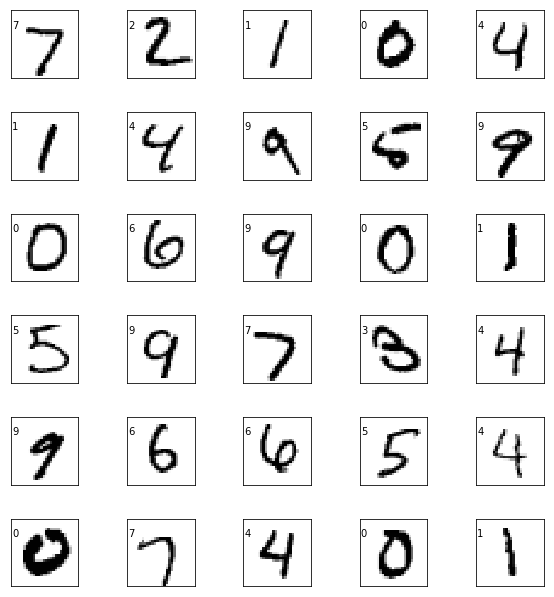

---------------------------------------------------


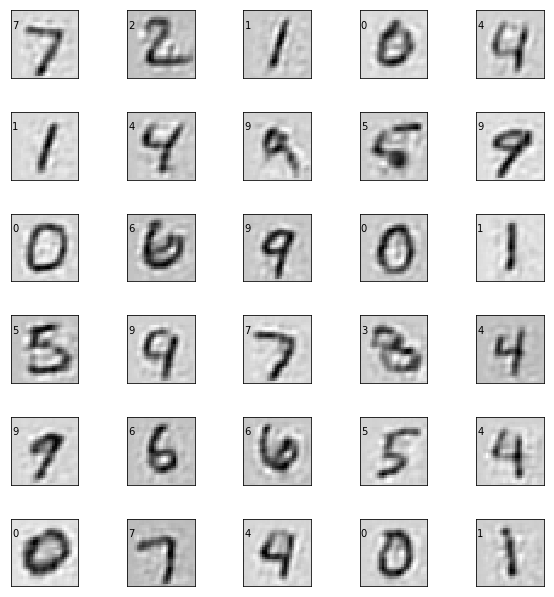

In [36]:
#Test Processing:
test_x = np.zeros((len(test_images),64))
output = []
with tf.Session() as sess:
    if os.path.exists('tmp/checkpoint'):        
        saver.restore(sess, 'tmp/model.ckpt')
        total_batch  = int(len(test_images)/batch_size)
        msg = "Test batch={:d}, lose={:.4f}"
        for b in tqdm(range(total_batch)):
            batch = test_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            feature1, cost,out = sess.run([feature,loss,conv_final], feed_dict={input_x:batch})
            output.append(out)
            test_x[b*batch_size:(b+1)*batch_size]=np.array(feature1)
            print(msg.format(b,cost))

    else :
        print("Please run training part first")
    fig1 = plt.figure(figsize=(8,8))
    fig1.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(test_images[i],[28,28])
        ax=fig1.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(output[0][i],[28,28])
        ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()

In [37]:
print(test_x)

[[0.00000000e+00 2.84827194e+01 0.00000000e+00 ... 0.00000000e+00
  7.40558243e+01 0.00000000e+00]
 [5.61124347e-02 3.84712524e+01 3.43189201e+01 ... 0.00000000e+00
  6.76429214e+01 0.00000000e+00]
 [1.28777609e+01 4.48421745e+01 2.59876995e+01 ... 0.00000000e+00
  8.30210342e+01 0.00000000e+00]
 ...
 [1.91956115e+00 7.34296799e+01 0.00000000e+00 ... 0.00000000e+00
  7.84040298e+01 0.00000000e+00]
 [0.00000000e+00 3.74192929e+00 6.48812437e+00 ... 0.00000000e+00
  7.96681595e+01 0.00000000e+00]
 [5.19415855e+01 3.72639275e+01 5.07749786e+01 ... 0.00000000e+00
  0.00000000e+00 1.78292408e+01]]


In [40]:
import time
from sklearn.svm import SVC
start = time.clock()

clf = SVC(kernel = 'poly') 
clf.fit(train_x, train_labels) 
elapsed = (time.clock() - start)
print("Time used:",elapsed)
score = clf.score(test_x, test_labels) 
print(" score: {:.6f}".format(score))

Time used: 342.72178600000007
 score: 0.939000
